## BigDL Wide & Deep Recommender Demo

Wide and Deep Learning Model, proposed by Google in 2016, is a DNN-Linear mixed model. Wide and deep learning has been used for Google App Store for their app recommendation.

In this tutorial, we'll introduce how to use BigDL to train a wide linear model and a deep neural network, which is called Wide & Deep model. Wide & Deep model combines the strength of memorization and generalization. It's useful for generic large-scale regression and classification problems with sparse input features(e.g., categorical features with a large number of possible feature values).

In [1]:
%pylab inline

import os
import sys
import numpy as np
import pandas as pd
import scipy as sp
import datetime as dt

from bigdl.dataset.transformer import *
from bigdl.dataset.base import *
from bigdl.nn.layer import *
from bigdl.nn.initialization_method import *
from bigdl.nn.criterion import *
from bigdl.optim.optimizer import *
from bigdl.util.common import *

redire_spark_logs()
show_bigdl_info_logs()
init_engine()
sc=get_spark_context()

Populating the interactive namespace from numpy and matplotlib


Define some helper function and variable.

In [2]:
COLUMNS = ["age", "workclass", "fnlwgt", "education", "education_num",
           "marital_status", "occupation", "relationship", "race", "gender",
           "capital_gain", "capital_loss", "hours_per_week", "native_country",
           "income_bracket"]

NUM_COLUMNS=15

LABEL_COLUMN = "label"

AGE, WORKCLASS, FNLWGT, EDUCATION, EDUCATION_NUM, MARITAL_STATUS, OCCUPATION, \
RELATIONSHIP, RACE, GENDER, CAPITAL_GAIN, CAPITAL_LOSS, HOURS_PER_WEEK, NATIVE_COUNTRY, \
LABEL = range(NUM_COLUMNS)

EDUCATION_VOCAB = ["Bachelors", "HS-grad", "11th", "Masters", "9th",
  "Some-college", "Assoc-acdm", "Assoc-voc", "7th-8th",
  "Doctorate", "Prof-school", "5th-6th", "10th", "1st-4th",
  "Preschool", "12th"] # 16
MARITAL_STATUS_VOCAB = ["Married-civ-spouse", "Divorced", "Married-spouse-absent",
    "Never-married", "Separated", "Married-AF-spouse", "Widowed"]
RELATIONSHIP_VOCAB = ["Husband", "Not-in-family", "Wife", "Own-child", "Unmarried",
    "Other-relative"]  # 6
WORKCLASS_VOCAB = ["Self-emp-not-inc", "Private", "State-gov", "Federal-gov",
    "Local-gov", "?", "Self-emp-inc", "Without-pay", "Never-worked"] # 9
GENDER_VOCAB = ["Female", "Male"]
AGE_BOUNDARIES = [18, 25, 30, 35, 40, 45, 50, 55, 60, 65]

def hashbucket(sth, bucketsize = 1000, start = 0):
    return (id(sth) % bucketsize + bucketsize) % bucketsize + start

def categorical_from_vocab_list(sth, vocab_list, default = -1, start = 0):
    if sth in vocab_list:
        return vocab_list.index(sth) + start
    else:
        return default + start
    
def get_boundaries(numage, boundaries, default = -1, start = 0):
    if numage == '?':
        return default + start
    else:
        for i in range(len(boundaries)):
            if numage < boundaries[i]:
                return i + start
        return len(boundaries) + start
    
def get_label(label):
    if label == ">50K" or label == ">50K.":
        return 2
    else:
        return 1
    
def read(file, sc):
    lines=sc.textFile(file).map(lambda line: list(map(lambda word: word.strip(), line.split(',')))).filter(lambda line: len(line) == NUM_COLUMNS)
    return lines

## 1. Prepare Data
Download training and testing data set from [Census Income Dataset](https://archive.ics.uci.edu/ml/datasets/Census+Income).
Read and parse the dataset into Spark RDD.

In [3]:
train_records = read('census/adult.data', sc)
test_records = read('census/adult.test', sc)

Training data set has 14 features age, workclass, fnlwgt, etc... and one label income_bracket. There is ten record of the dataset.

In [4]:
pd.DataFrame(train_records.take(10), columns=COLUMNS)

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K


## 2. Transform data to BigDL' Sample
BigDL's Sample is a data structure who represents the features and label of data. So each record will be transform to a BigDL Sample, and BigDL will train the Wide&Deep with these Samples. 

The input BigDL Wide&Deep model required,  are two input tensors, one is SparseTensor for the Wide model, another is a DenseTensor for the Deep model.

In [5]:
def to_sample(row):
    wide_column_shape = np.array([3049])
    wide_column_indices = np.arange(8)
    wide_column_values = np.ones(8)
    education = categorical_from_vocab_list(row[EDUCATION], EDUCATION_VOCAB, start = 1)  # 1 - 16
    marital_status = categorical_from_vocab_list(row[MARITAL_STATUS], MARITAL_STATUS_VOCAB, start = 1) # 1 - 7
    relationship = categorical_from_vocab_list(row[RELATIONSHIP], RELATIONSHIP_VOCAB, start = 1) # 1 - 6
    workclass = categorical_from_vocab_list(row[WORKCLASS], WORKCLASS_VOCAB, start = 1) # 1 - 9
    occupation = hashbucket(row[OCCUPATION], 1000, start = 1) # 1 - 1000
    age_buckets = get_boundaries(int(row[AGE]), AGE_BOUNDARIES, start = 1) # 1 - 11
    education_x_occupation = hashbucket(row[EDUCATION] + row[OCCUPATION], 1000, start = 1) # 1 - 1000
    age_x_education_occupation = hashbucket(str(age_buckets) + row[EDUCATION] + row[OCCUPATION], 1000, start = 1) # 1 - 1000
    
    wide_column_indices[0] = education - 1
    wide_column_indices[1] = marital_status + 16 - 1
    wide_column_indices[2] = relationship + 23 - 1
    wide_column_indices[3] = workclass + 29 - 1
    wide_column_indices[4] = occupation + 38 - 1
    wide_column_indices[5] = age_buckets + 1038 - 1
    wide_column_indices[6] = education_x_occupation + 1049 - 1
    wide_column_indices[7] = age_x_education_occupation + 2049 - 1
    
    deep_column1 = np.zeros(43)
    deep_column1[0] = row[AGE]
    deep_column1[1] = row[EDUCATION_NUM]
    deep_column1[2] = row[CAPITAL_GAIN]
    deep_column1[3] = row[CAPITAL_LOSS]
    deep_column1[4] = row[HOURS_PER_WEEK]
    deep_column1[workclass + 4] = 1
    deep_column1[education + 13] = 1
    deep_column1[marital_status + 29] = 1
    deep_column1[relationship + 36] = 1
    
    deep_column2 = np.zeros(1)
    deep_column2[0] = hashbucket(row[NATIVE_COUNTRY], 1000, 1)
    
    label = get_label(row[LABEL])
    wide_column_values=wide_column_values.astype("float32")
    deep_column1=deep_column1.astype("float32")
    deep_column2=deep_column2.astype("float32")


    wide_input = JTensor.sparse(wide_column_values, wide_column_indices, wide_column_shape, bigdl_type="float")
    deep_input1 = JTensor.from_ndarray(deep_column1)
    deep_input2 = JTensor.from_ndarray(deep_column2)
    return Sample.from_jtensor([wide_input, deep_input1, deep_input2], label)

train_data = train_records.map(lambda line: to_sample(line))
test_data = test_records.map(lambda line: to_sample(line))

Cache the Training and Testing data RDD.

In [6]:
train_data.cache()
print "Total train records: %s" % train_data.count()
test_data.cache()
print "Total test records: %s" % test_data.count()

Total train records: 32561
Total test records: 16281


## 3. Create the Wide&Deep model.

In [7]:
def build_model(class_num = 2):
    # wide
    wideChannel = Identity().set_name("wide_input")()
    wideModel = SparseLinear(3049, class_num).set_name("wide_fc").set_init_method(Zeros(), Zeros())(wideChannel)

    # deep
    deepChannel1 = Identity().set_name("deep_input1")()
    deepChannel2 = LookupTable(1000, 8).set_init_method(RandomNormal(0, 0.001)).set_name("embedding_1")()
    reshape = Reshape([8], True)(deepChannel2)
    joinTable = JoinTable(1, 1).set_name("merge1")([deepChannel1, reshape])
    fc1 = Linear(51, 100).set_init_method(bias_init_method=Zeros()).set_name("fc_1")(joinTable)
    relu1 = ReLU().set_name("relu_1")(fc1)
    fc2 = Linear(100, 75).set_init_method(bias_init_method=Zeros()).set_name("fc_2")(relu1)
    relu2 = ReLU().set_name("relu_2")(fc2)
    fc3 = Linear(75, 50).set_init_method(bias_init_method=Zeros()).set_name("fc_3")(relu2)
    relu3 = ReLU().set_name("relu_3")(fc3)
    fc4 = Linear(50, 25).set_init_method(bias_init_method=Zeros()).set_name("fc_4")(relu3)
    relu4 = ReLU().set_name("relu_4")(fc4)
    fc5 = Linear(25, class_num).set_init_method(bias_init_method=Zeros()).set_name("deep_fc")(relu4)
#     merge
    merge = CAddTable().set_name("merge2")([wideModel, fc5])
    classifier = LogSoftMax().set_name("loss")(merge)
    
    wide_deep = Model([wideChannel, deepChannel1, deepChannel2], [classifier])
    return wide_deep
   
wide_n_deep=build_model()

creating: createIdentity
creating: createSparseLinear
creating: createZeros
creating: createZeros
creating: createIdentity
creating: createLookupTable
creating: createRandomNormal
creating: createReshape
creating: createJoinTable
creating: createLinear
creating: createZeros
creating: createReLU
creating: createLinear
creating: createZeros
creating: createReLU
creating: createLinear
creating: createZeros
creating: createReLU
creating: createLinear
creating: createZeros
creating: createReLU
creating: createLinear
creating: createZeros
creating: createCAddTable
creating: createLogSoftMax
creating: createModel


## 4. Create optimizer and training the model

In [8]:
wide_n_deep=build_model()

# Create an Optimizer
batch_size = 2048

optimizer = Optimizer(
    model=wide_n_deep,
    training_rdd=train_data,
    criterion=ClassNLLCriterion(),
    optim_method=Adam(learningrate = 0.001, learningrate_decay=0.001),
    end_trigger=MaxEpoch(20),
    batch_size=batch_size)

# Set the validation logic
optimizer.set_validation(
    batch_size=batch_size,
    val_rdd=test_data,
    trigger=EveryEpoch(),
    val_method=[Top1Accuracy()]
)
log_dir='/tmp/bigdl_summaries/'
app_name='wide_n_deep-'+dt.datetime.now().strftime("%Y%m%d-%H%M%S")
wide_n_deep.save_graph_topology(log_dir + app_name)
train_summary = TrainSummary(log_dir=log_dir,
                                     app_name=app_name)
train_summary.set_summary_trigger("LearningRate", SeveralIteration(1))
train_summary.set_summary_trigger("Parameters", SeveralIteration(1))
val_summary = ValidationSummary(log_dir=log_dir,
                                        app_name=app_name)
optimizer.set_train_summary(train_summary)
optimizer.set_val_summary(val_summary)
print "saving logs to %s" % (log_dir + app_name)

creating: createIdentity
creating: createSparseLinear
creating: createZeros
creating: createZeros
creating: createIdentity
creating: createLookupTable
creating: createRandomNormal
creating: createReshape
creating: createJoinTable
creating: createLinear
creating: createZeros
creating: createReLU
creating: createLinear
creating: createZeros
creating: createReLU
creating: createLinear
creating: createZeros
creating: createReLU
creating: createLinear
creating: createZeros
creating: createReLU
creating: createLinear
creating: createZeros
creating: createCAddTable
creating: createLogSoftMax
creating: createModel
creating: createClassNLLCriterion
creating: createAdam
creating: createMaxEpoch
creating: createDistriOptimizer
creating: createEveryEpoch
creating: createTop1Accuracy
creating: createTrainSummary
creating: createSeveralIteration
creating: createSeveralIteration
creating: createValidationSummary
saving logs to /tmp/bigdl_summaries/wide_n_deep-20180410-224322


Train the network. Wait some time till it finished.. Voila! You've got a trained model

In [9]:
%%time
# Boot training process
trained_model = optimizer.optimize()
print "Optimization Done."

Optimization Done.
CPU times: user 6.26 ms, sys: 3.55 ms, total: 9.81 ms
Wall time: 43.8 s


## 5. Evaluate the trained model
Will return a Top1 Accuracy about 84%.

In [10]:
%%time
evaluate_result=trained_model.evaluate(test_data, 2, [Top1Accuracy()])
print "Top1 accuracy: %s" % evaluate_result[0].result
#evaluate_result=trained_model.evaluate(train_data, 2, [Top1Accuracy()])
#print "Top1 accuracy: %s" % evaluate_result[0].result

creating: createTop1Accuracy
Top1 accuracy: 0.840795993805
CPU times: user 7.85 ms, sys: 143 µs, total: 7.99 ms
Wall time: 1.17 s


## 6. Draw the convergence curve

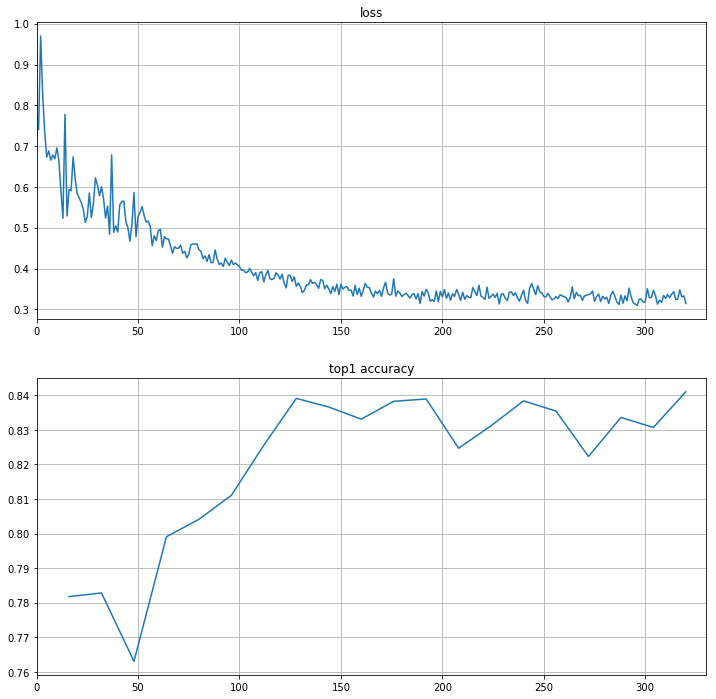

In [11]:
loss = np.array(train_summary.read_scalar("Loss"))
top1 = np.array(val_summary.read_scalar("Top1Accuracy"))

plt.figure(figsize = (12,12))
plt.subplot(2,1,1)
plt.plot(loss[:,0],loss[:,1],label='loss')
plt.xlim(0,loss.shape[0]+10)
plt.grid(True)
plt.title("loss")
plt.subplot(2,1,2)
plt.plot(top1[:,0],top1[:,1],label='top1')
plt.xlim(0,loss.shape[0]+10)
plt.title("top1 accuracy")
plt.grid(True)

## 7. Open tensorboard to watch the training metrics
tensorboard --logdir /tmp/bigdl_summaries